In [93]:
#| default_exp hwc2node

In [2]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
from fastcore.utils import *
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.linalg
import scipy.signal as signal


Establish a basic class of hot water cylinder that can be used to model a stratified hot water cylinder. The model is based on the following assumptions:


[Model Predictive Control of Heat Pump Water Heaters for Energy Efficiency](https://www.aceee.org/files/proceedings/2014/data/papers/1-296.pdf)

[Dynamic modeling of a sensible thermal energy storage tank with an
immersed coil heat exchanger under three operation modes](https://engineering.purdue.edu/JainResearchLab/pdf/dynamic-modeling-sensible-thermal-energy-storage-immersed-coil-heat-exchanger.pdf)

\section{Nomenclature}

$\Delta \quad$ internal heat transfer scaling parameter

$\dot{m}_{c} \quad$ mass flow rate of IHX coil fluid

$\dot{m}_{c w} \quad$ mass flow rate of inlet domestic cold water

$\dot{m}_{t} \quad$ discharge mass flow rate through tank

$\dot{Q}_{\text {coil }} \quad$ heat transfer rate due to IHX coil

$\dot{Q}_{j+1}$ heat transfer rate between nodes $j$ and $j+1$

$\dot{Q}_{j-1} \quad$ heat transfer rate between nodes $j$ and $j-1$

$\dot{Q}_{\text {wall }}$ heat transfer rate for losses to surroundings

A cross-sectional area of node control volume

$A_{w} \quad$ wall contact surface area

$c_{v} \quad$ specific heat capacity of water

$j \quad$ current node in iterative energy equations

$j+1 \quad$ represents node below node $j$

$\begin{array}{ll}j-1 & \text { represents node above node } j \\ k & \text { internal node interaction heat transfer coefficient } \\ k_{w} & \text { lumped heat transfer coefficient for losses across walls } \\ m & \text { mass of node } \\ s_{1} & \text { discharge fluid correction factor } \\ T & \text { temperature } \\ t & \text { time } \\ T_{c w} & \text { domestic cold water temperature } \\ T_{e n} & \text { IHX coil fluid inlet temperature } \\ T_{e x} & \text { IHX coil fluid outlet temperature } \\ w_{t} & \text { tank wall thickness } \\ z & \text { vertical height variable with respect to tank bottom }\end{array}$

In [46]:
#| export
class HWC():
  """
  Model of a Hot Water Cylinder using a nodal approach.
  """
  def __init__(self,
              element = 3,        # kW
              T_set = 75,         # °C
              T_deadband = 2,     # °C
              radius =.25,        # m
              height = 1.1,       # m
              U = 0.8):
    super(HWC, self).__init__()
    self.U = U/60     # 0.5-0.8 kJ/min m2K typical heat transfer losses to ambient  [0.5 kJ/min m2K Jack Paper] kW/m2K
    self.split = np.array([.7,.3])
    self.Cv = 4.184 #kJ/kgK
    self.ρ = 1000 #kg/m3
    self.T_ambient = 15 #  Air temperature that the cylinder located in °C
    self.T_cold = 15 # Make up water temperature °C
    self.T_demand = 45 #T_demand - temperature of the end use (shower)  °C
    self.T_deadband = T_deadband #T_deadband  - thermostat deadband °C
    self.T_set = T_set #T_set - thermostat set point °C
    self.element = element # kW = kJ/s
    self.radius = radius
    self.height = height
    self.T_set_bu = 60
    temperature = self.T_set + np.random.uniform(-5, 0)
    self.temperatures = np.array([temperature,temperature+ np.random.uniform(-5, 0)])
    self.thermostat = np.array([0,0]) # bulk / nodal high / nodal low
    # self._thermostat()
    
  @property
  def surface_area(self): return 2* np.pi * self.radius * self.height + 2 * np.pi * self.radius**2 # m2

  @property
  def volume(self): return np.pi * self.radius ** 2 * self.height  # m3

  @property
  def m(self): return self.split * self.volume * self.ρ # kg

  @property
  def h(self): return self.split * self.height # kg

  @property
  def heat_capacity(self): return self.Cv * self.ρ * self.volume # kJ/K

  @property
  def A(self): return np.pi * self.radius**2 # m2 

  @property
  def cylinder_wall_area(self): return 2* np.pi * self.radius * self.height  # m2 


  @property
  def uas(self): 
    uas = self.split * self.U * self.cylinder_wall_area   # unit  heat transfer coefficient kW/K
    uas[0]  += self.U * self.A               # Add end heat losses
    uas[1] += self.U * self.A               # Add end heat losses
    return uas #  

  @property
  def nj(self): return self.heat_capacity / self.nodes

  @property
  def k(self): return 50                                        

  @property
  def s1(self): return 1                                        

  # @property
  # def Δ(self):  return self.delta                                        # internal heat transfer scaling parameter 


Provide a mechanisim to set the thermostat state based on the model temperature

$$
\begin{aligned}
\left\{\begin{array}{c}
\frac{d T_{1}}{d t} \\
\frac{d T_{2}}{d t} \\
\end{array}\right\} 


& =\left[\begin{array}{ccc}
-\frac{1}{m_{1} c_{v}}\left(\frac{k A}{h_{1}}+\frac{k_{w} A_{w}}{w_{t}}+\dot{m} c_{v}\right) & \frac{1}{m_{1} c_{v}}\left(\frac{k A}{h_{1}}+\dot{m} c_{v}\right) \\
\frac{1}{m_{2} c_{v}}\left(\frac{k A}{h_{2}}\right) & -\frac{1}{m_{2} c_{v}}\left(\frac{k A}{h_{2}}+
\frac{k_{w} A_{w}}{w_{t}}+\dot{m} c_{v}\right) \\
\end{array}\right]\left\{\begin{array}{c}
T_{1} \\
T_{2} 
\end{array}\right\} \\
& +\left[\begin{array}{ccc}
0 & \frac{1}{m_{1}}\left(T_{2}^{e}-T_{1}^{e}\right) & ua_{[0]} \\
\frac{1}{m_{2}}\left(T_{e n}-T_{2}^{e}\right) & \frac{1}{m_{1}}\left(T_{2}^{e}-T_{1}^{e}\right) & ua_{[1]}  \\
\end{array}\right]\left\{\begin{array}{c}
\dot{power} \\
\dot{m} \\
T_{amb}
\end{array}\right\}
\end{aligned}
$$

In [47]:
#| export
@patch
def make_matrix(self:HWC, action = None, flow = None):
    A = np.zeros((2,2))
    A[0][0] = -(1 / (self.m[0] * self.Cv)) * \
               (self.k * self.A / self.h[0] + \
                self.uas[0] + \
                flow * self.ρ * self.Cv)
    A[0][1] =  (1 / (self.m[0] * self.Cv)) * \
               (self.k * self.A / self.h[0]  + \
                flow * self.ρ * self.Cv )
    A[1][0] =  (1 / (self.m[1] * self.Cv)) * \
               (self.k * self.A / self.h[1]   )
    A[1][1] = -(1 / (self.m[1] * self.Cv)) * \
               (self.k * self.A / self.h[1]  +\
                self.uas[1] + \
                flow * self.ρ * self.Cv)

    B= np.zeros((2,3))
    B[0 , 0]   = 0     
    B[1 , 0]   = self.element / self.m[1]         # add element to the bottom node
    B[0 , 1]   = 1/self.m[0] * (self.temperatures[1]-self.temperatures[0])    
    B[1 , 1]   = 1/self.m[1] * (self.T_cold-self.temperatures[1])          # add element to the bottom node
    B[: , 2]   = self.uas/ (self.m * self.Cv)   # Energy flow as heat loss to the room from the cylinder wall


    # for j in range(0,self.nodes-1):
    #     B[j,1] =  flow*self.s1 * self.Cv  * (self.temperatures[j+1] - self.temperatures[j]) # add water flow to the node
    # B[-1,1] =   flow*self.s1 * self.Cv * min(0,(self.T_cold - self.temperatures[-1])) # add cold water flow to the last node

    return A, B

In [81]:
#| export
@patch
def _update_model(self:HWC, action = None, flow = None, timestep_sec=60):
    A,B = self.make_matrix(action = action, flow = flow)
    #     timesteps = np.linspace(0,micro_step,10)
    steps = 5
    # # print('-----')    
    # print(A)
    # print(B)
    timesteps = np.linspace(0,timestep_sec,steps)
    tempered_flow = (flow*(self.T_demand-self.T_cold) /(self.temperatures[0]-self.T_cold).clip(min=0))
    u = np.ones([len(timesteps),3])*np.array([action, tempered_flow*self.ρ, self.T_ambient])
    # print(u)
    sys = signal.StateSpace(A/steps , B /steps, np.ones((1,2)) , np.zeros((1,3)))
    # signal.step(sys, self.temperatures, u)
    _,_,temperature =signal.lsim(sys, u, timesteps, self.temperatures)
    #     u = np.ones([len(timesteps),3])*np.array([action, flow>0, self.T_ambient])
    # print(signal.lsim(sys, u, timesteps, self.temperatures))
    #     _,_,temperature = signal.lsim(sys, u, timesteps, self.temperatures)
    self.temperatures = temperature[-1]
    # print(self.temperatures)
    return 


In [82]:
env = HWC(T_set=55, element=3)
print(env.temperatures)
temp = []
for step in range(60):
    env._update_model(action = 1 if step <30 else 0, flow = 0, timestep_sec=60)
    temp.append(env.temperatures)

[51.43422341 49.01803084]


In [84]:
expected_temp_rise = 3 / (env.volume * env.ρ * env.Cv) * 60 *60
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) * 60/1000 # countinuous load in W x h
print(f'Expected temperature rise = {expected_temp_rise-wall_losses:.1f}')
print(f'Model temperature change = {temp[-1].mean() - temp[0].mean():.1f}°C')

Expected temperature rise = 11.9
Model temperature change = 1.8°C


$k_{j-1}= \begin{cases}k_{j-1} \Delta\left|T_{j}-T_{j-1}\right|, & \text { if } T_{j}>T_{j-1} \\ k_{j-1}, & \text { otherwise }\end{cases}$

$k_{j+1}=\left\{\begin{array}{ll}k_{j+1} \Delta\left|T_{j}-T_{j+1}\right|, & \text { if } T_{j}<T_{j+1} \\ k_{j+1}, & \text { otherwise }\end{array}\right.$,

Text(0.5, 0.98, 'dd')

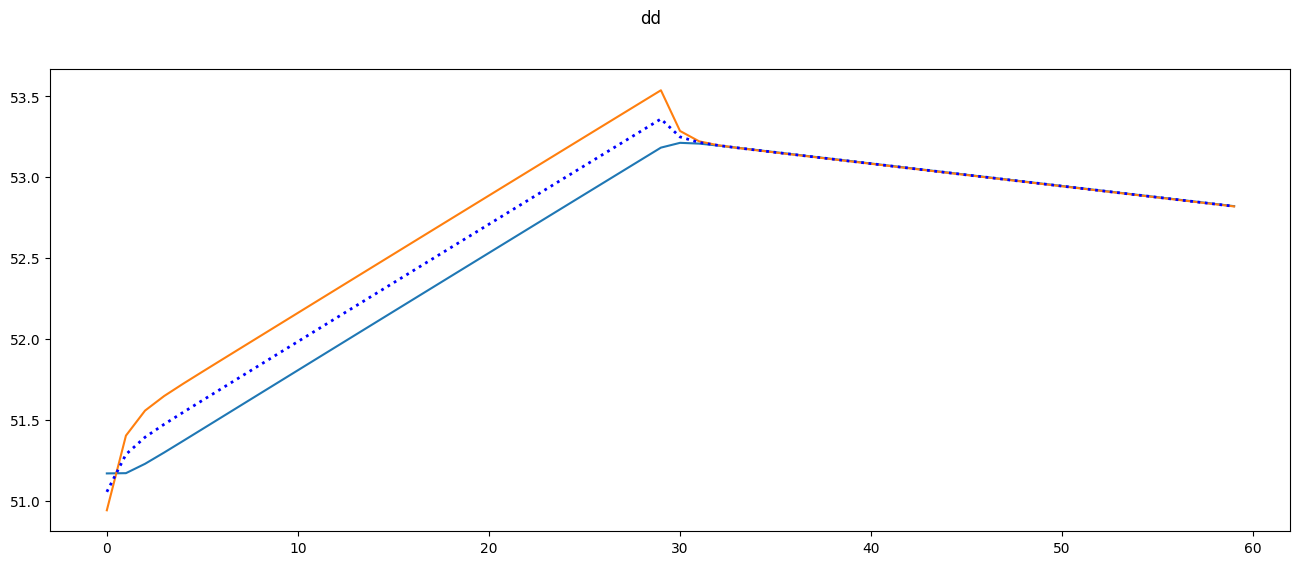

In [85]:


fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot(np.vstack(temp).mean(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('dd')

In [86]:
temp[-1].mean(),temp[0].mean(),temp[-1].mean() - temp[0].mean()
# env.volume*env.ρ * env.Cp *( temp[-1].mean() - temp[0].mean()) 

(52.81988989586429, 51.05369728615659, 1.7661926097077014)

In [88]:
expected_temp_rise = 3 / (env.volume * env.ρ * env.Cv) * 60 *60
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) * 60/1000 # countinuous load in W x h
print(f'Expected temperature rise = {expected_temp_rise-wall_losses:.1f}')
print(f'Model temperature change = {temp[-1].mean() - temp[0].mean():.1f}°C')

Expected temperature rise = 11.9
Model temperature change = 1.8°C


# Model Operation

## Initialisation

Text(0.5, 0.98, 'Random initial states of charge for 10 different models')

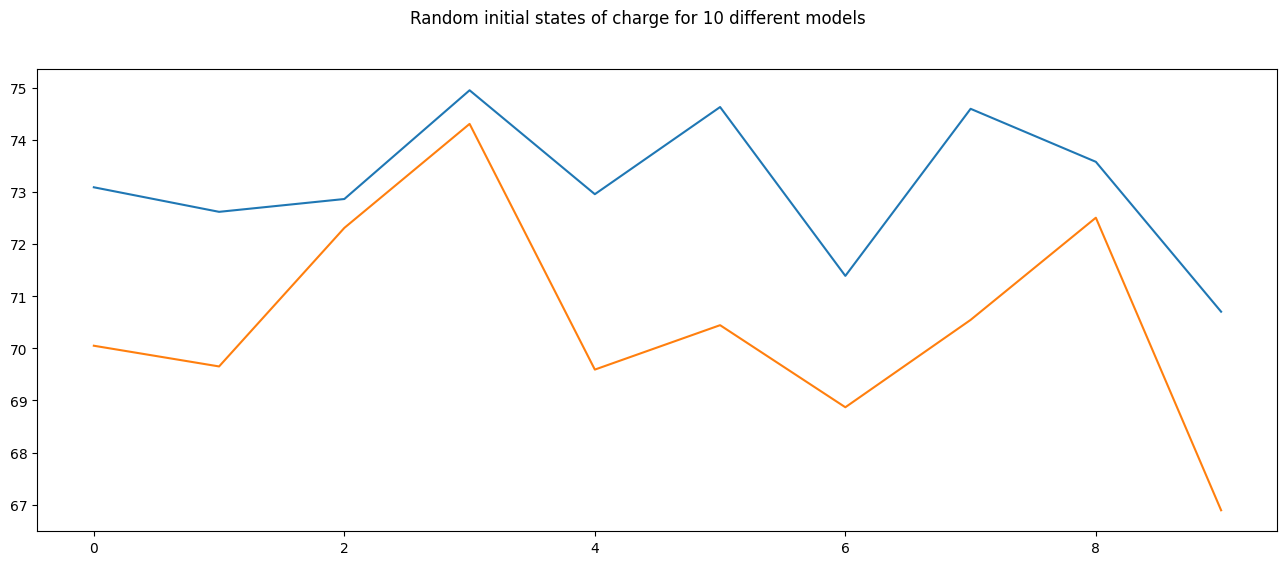

In [66]:
temp = []
for i in range(10):
    env = HWC(T_set=75, element=3)
    temp.append(env.temperatures)
    assert env.temperatures[0]<= 75.5
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('Random initial states of charge for 10 different models')

In [67]:
env = HWC(T_set=75, element=3, delta=5000, height=1, radius=1/2, nodes=10)
# check that the volume and areas are correct
assert env.volume == np.pi/4
assert env.x_section_area == np.pi/4

TypeError: HWC.__init__() got an unexpected keyword argument 'delta'

## Passive Losses - No Heating + No Flow

Text(0.5, 0.98, 'Passive Losses - No Heating + No Flow over 60 minutes')

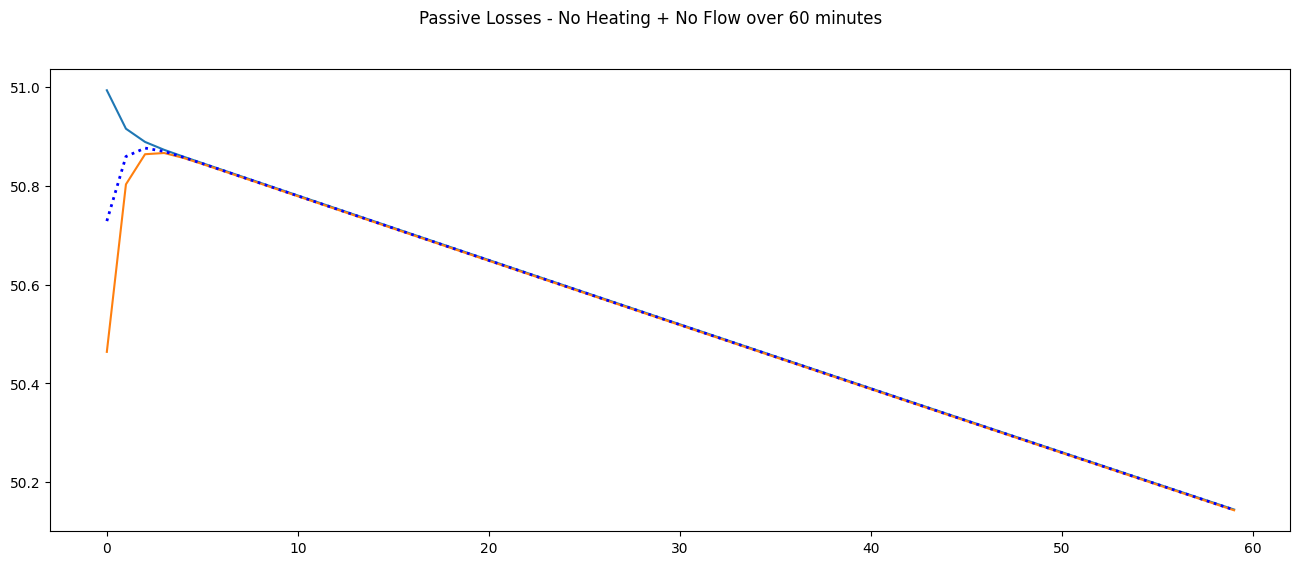

In [89]:
env = HWC(T_set=55, element=3)
temp = []
minutes = 60
for i in range(minutes):
    env._update_model(action = 0 , flow = 0, timestep_sec=60)
    temp.append(env.temperatures)
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot(np.vstack(temp).mean(axis=1), lw=2, ls=':', c='blue')
fig.suptitle(f'Passive Losses - No Heating + No Flow over {minutes} minutes') 

### Compare to calulation from first principles

In [57]:
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) *60/1000*24 # countinuous load in W x h
print(f'Environmetal Losses: \nCylinder Surface Area: {env.surface_area:.1f} m2 \nU {env.U:.2f} W/m2K \nMean temperature difference {(np.vstack(temp).mean() - env.T_ambient):.1f}°C \
\nExpected losses ~ {round(wall_losses,2)} kWh')
model_losses = env.volume * 1000 * env.Cv * (temp[0].mean() - temp[-1].mean()) / 60 * 24
print(f'Model Losses: {env.volume*1000:.0f} litre Cylinder which drops {temp[0].mean() - temp[-1].mean():.1f}°C in {minutes} minutes ~ {model_losses:.1f} kWh')


Environmetal Losses: 
Cylinder Surface Area: 2.1 m2 
U 0.01 W/m2K 
Mean temperature difference 36.9°C 
Expected losses ~ 1.5 kWh
Model Losses: 216 litre Cylinder which drops 0.7°C in 60 minutes ~ 268.8 kWh


The standing heat loss for a tank should be in the order of 1.7 kWh / day for a tank at 55 degrees. https://sustainableengineering.co.nz/portfolio-item/dhw-tanks-w-k-from-kwh-day/

## No Heating + Flow rate of 10 litres per minure for 10 minutes

Text(0.5, 0.98, 'No Heating + Flow rate of 10 litres per minure for 10 minutes')

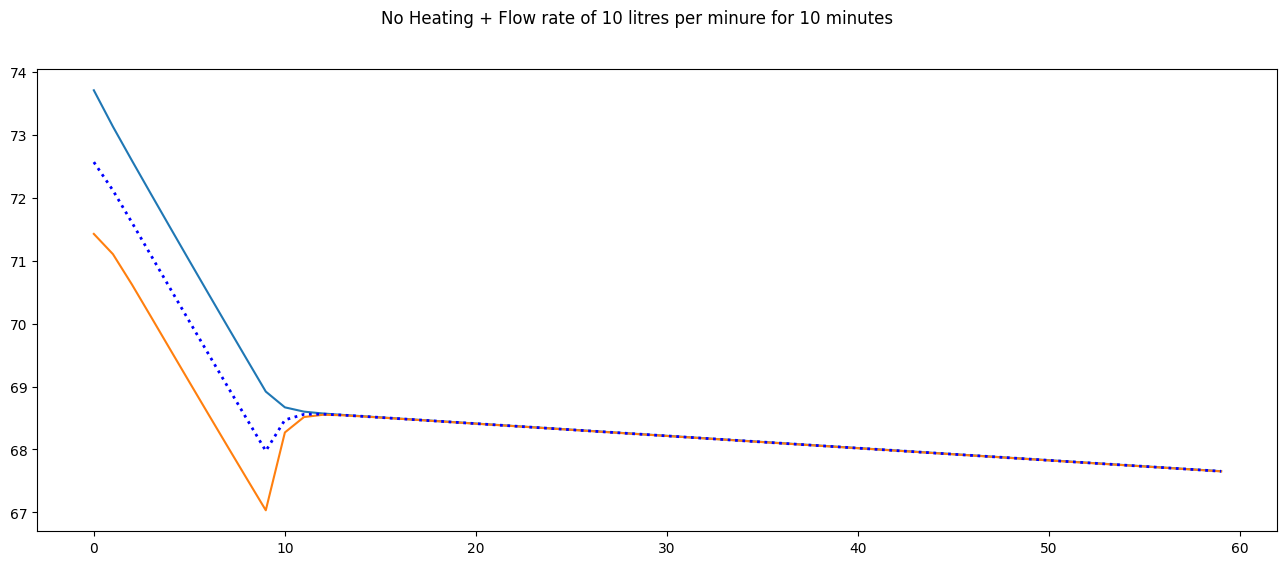

In [90]:
env = HWC(T_set=75, element=3)
flow = 10/60/1000 # 10 litres per minute
temp = []
minutes = 60
for minute in range(minutes):
    action = 0 #np.random.randint(0,2)
    env._update_model(action = action , flow = shower if minute < 10 else 0, timestep_sec=60)
    temp.append(env.temperatures)

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot(np.vstack(temp).mean(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('No Heating + Flow rate of 10 litres per minure for 10 minutes')

# Heating Bottom Element + No Flow

Text(0.5, 0.98, 'dd')

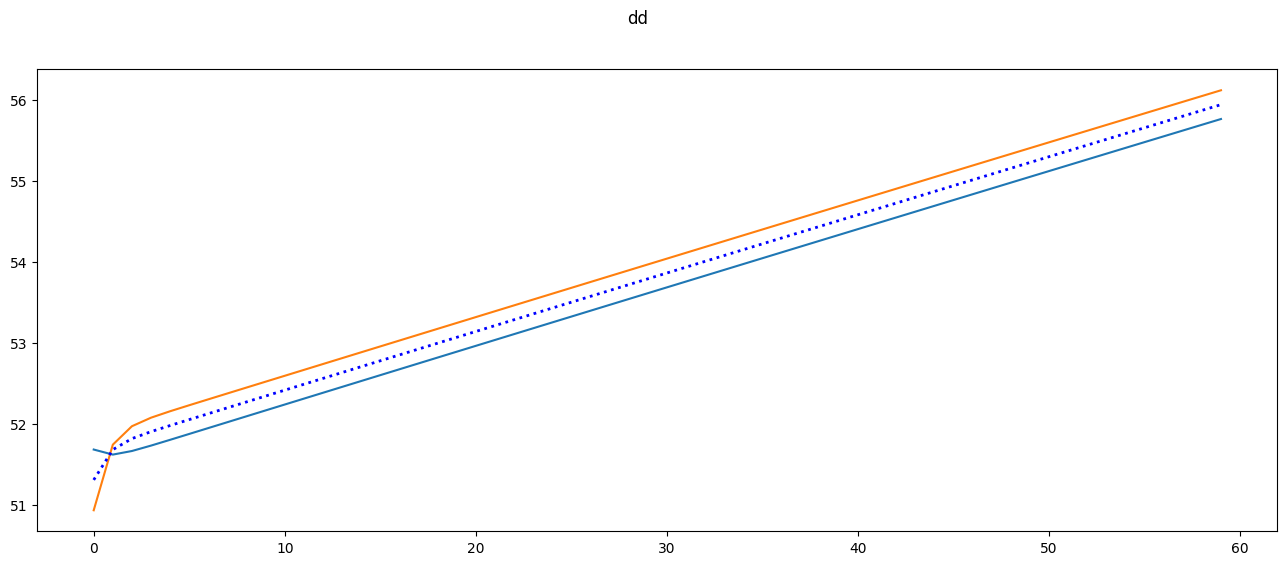

In [92]:
env = HWC(T_set=55, element=3)
temp = []
minutes = 60
for i in range(minutes):
    env._update_model(action = 1, flow = 0, timestep_sec=60)
    temp.append(env.temperatures)

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot(np.vstack(temp).mean(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('dd')

In [30]:
expected_temp_rise = 3 / (env.volume * env.ρ * env.Cv) * 60 *60
# In 1 hour
Tfinal = 3600 * env.element / (env.volume * env.ρ * env.Cv) + temp[0].mean()


wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) * 60/1000 # countinuous load in W x h
print(f'Expected temperature rise = {Tfinal:.1f}')
print(f'Model final temperature = {temp[-1].mean():.1f}°C')

Expected temperature rise = 62.1
Model final temperature = 59.5°C


In [20]:
# env = HWC(T_set=75, element=3, delta=100000,nodes=60)
# temp = []
# for i in range(60):
#     env._thermostat()
#     print(env.thermostat)
#     action = np.random.choice([0,0,0,1])
#     if action:
#         for j in range(6):
#             env._update_model(action = action * env.thermostat[0] , flow = 0, timestep_sec=10)
#     else:
#         env._update_model(action = action * env.thermostat[0] , flow = 0)
#     temp.append(env.temperatures)
#     # print(env.temperatures.mean(),env.thermostat, env.temperatures[0]-env.temperatures[-1],env.temperature )
# # fig, ax = plt.subplots(figsize=(20,10))
# # ax.plot(env._temps.reshape(-1,env.nodes))
# fig, ax = plt.subplots(figsize=(16,6))
# ax.plot(np.vstack(temp))
# fig.suptitle('dd')

In [45]:

out = .05 / 2 / 30 / 60
env = HWC(T_set=75, element=3)
temp = []
for i in range(60):
    env._thermostat()
    # print(env.thermostat)
    action = 0

    env._update_model(action = action , flow = out)
    temp.append(env.temperatures)
    # print(env.temperatures.mean(),env.thermostat, env.temperatures[0]-env.temperatures[-1],env.temperature )
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(env._temps.reshape(-1,env.nodes))
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('dd')


AttributeError: 'HWC' object has no attribute '_thermostat'

Provide some initialisation functions to set the model up with some default values

In [23]:
# hwc = HWC(T_set=55, T_deadband=2, element=3000, radius=.2, height=1.5)
# results = []
# for index, row in df.loc['2020-01-01'].iterrows():
#   raw_flow = 0
#   hwc.flow = raw_flow*(hwc.T_demand-hwc.T_cold)/(hwc.T-hwc.T_cold)
#   hwc._thermostat()
#   hwc.T = hwc._update_temperatures(action=0)
#   results.append([index,hwc.T, hwc.thermostat, hwc.flow,row.cost])
# results = pd.DataFrame(results, columns=['time','temperature','thermostat','flow','cost']).set_index('time')

In [24]:
# print(f'The HWC volume is {int(hwc.volume*1000)} liters')
# print(f'The HWC surface area is {hwc.surface_area:.2f} m2')
# print(f'One day standing heat losses  : {4.128*.188*(results.temperature.max()-results.temperature.min()):.2f} kWh')

In [25]:
# fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
# ax.plot(results.temperature)
# ax.set_ylabel('°C')
# ax.set_title('Temperature')
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

In [26]:
#| hide
import nbdev; nbdev.nbdev_export()